### Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapezoid
from ground_state_wavefunctions import Sr1s, Sr2s, Sr3s, Sr2p
from ground_state_wavefunctions import Sk1s, Sk2s, Sk3s, Sk2p

### Coefficients

In [2]:
# Read data from CSV
file_path = "/home/konsster/Desktop/AUThPhysDepart/Computational_Quantum_Physics_and_Applications/Project_1/data/orbitals_data.csv"
data = pd.read_csv(file_path)

atomic_numbers = {'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6,
                  'N': 7, 'O': 8, 'F': 9, 'Ne': 10}

# Create separate dictionaries for each coefficient type
coeffs_1s = {}
coeffs_2s = {}
coeffs_2p = {}

# For each row
for _, row in data.iterrows():
    element = row['Element']
    orbital = row['orbitals']
    z = row['z_coeff']
    
    # Special case for He: all coefficients go to coeffs_1s
    if element == 'He':
        if not pd.isna(row['coeff(1s)']):
            coeffs_1s.setdefault(element, {}).setdefault(orbital, []).append((z, row['coeff(1s)']))
        if not pd.isna(row['coeff(2s)']):
            coeffs_1s.setdefault(element, {}).setdefault(orbital, []).append((z, row['coeff(2s)']))
        if not pd.isna(row['coeff(2p)']):
            coeffs_1s.setdefault(element, {}).setdefault(orbital, []).append((z, row['coeff(2p)']))
    else:
        # Coefficient for coeff(1s)
        if not pd.isna(row['coeff(1s)']):
            coeffs_1s.setdefault(element, {}).setdefault(orbital, []).append((z, row['coeff(1s)']))
        # Coefficient for coeff(2s)
        if not pd.isna(row['coeff(2s)']):
            coeffs_2s.setdefault(element, {}).setdefault(orbital, []).append((z, row['coeff(2s)']))
        # Coefficient for coeff(2p)
        if not pd.isna(row['coeff(2p)']):
            coeffs_2p.setdefault(element, {}).setdefault(orbital, []).append((z, row['coeff(2p)']))

### Wavefunctions in Position and Momentum Space

In [3]:
### Wavefunctions in Position and Momentum Space
def R_1s(r, element):
    """1s wavefunction in position space"""
    total = 0.0
    for orbital_type in ['1s', '2s', '3s']:  # Include all s orbitals
        if orbital_type in coeffs_1s.get(element, {}):
            for z, c in coeffs_1s[element][orbital_type]:
                if orbital_type == '1s':
                    total += c * Sr1s(z, r)
                elif orbital_type == '2s':
                    total += c * Sr2s(z, r)
                elif orbital_type == '3s':
                    total += c * Sr3s(z, r)
    return total

def R_2s(r, element):
    """2s wavefunction in position space"""
    total = 0.0
    if '2s' in coeffs_2s.get(element, {}):
        for z, c in coeffs_2s[element]['2s']:
            total += c * Sr2s(z, r)
    return total

def R_2p(r, element):
    """2p wavefunction in position space"""
    total = 0.0
    if '2p' in coeffs_2p.get(element, {}):
        for z, c in coeffs_2p[element]['2p']:
            total += c * Sr2p(z, r)
    return total

def K_1s(k, element):
    """1s wavefunction in momentum space"""
    total = 0.0
    for orbital_type in ['1s', '2s', '3s']:
        if orbital_type in coeffs_1s.get(element, {}):
            for z, c in coeffs_1s[element][orbital_type]:
                if orbital_type == '1s':
                    total += c * Sk1s(z, k)
                elif orbital_type == '2s':
                    total += c * Sk2s(z, k)
                elif orbital_type == '3s':
                    total += c * Sk3s(z, k)
    return total

def K_2s(k, element):
    """2s wavefunction in momentum space"""
    total = 0.0
    if '2s' in coeffs_2s.get(element, {}):
        for z, c in coeffs_2s[element]['2s']:
            total += c * Sk2s(z, k)
    return total

def K_2p(k, element):
    """2p wavefunction in momentum space"""
    total = 0.0
    if '2p' in coeffs_2p.get(element, {}):
        for z, c in coeffs_2p[element]['2p']:
            total += c * Sk2p(z, k)
    return total

# Check for He (optional)
if 'He' in coeffs_1s:
    r_test = 0.5
    k_test = 0.5
    print(f"\nWavefunction check for He at r={r_test}, k={k_test}:")
    print(f"R_1s(He): {R_1s(r_test, 'He'):.6f}")
    print(f"K_1s(He): {K_1s(k_test, 'He'):.6f}")


Wavefunction check for He at r=0.5, k=0.5:
R_1s(He): 1.848232
K_1s(He): 1.340522


### Density functions in Position and Momentum Space

In [4]:
def electron_config(element):
    """Returns the number of electrons per orbital for each element"""
    config = {
        'He': {'1s': 2},
        'Li': {'1s': 2, '2s': 1},
        'Be': {'1s': 2, '2s': 2},
        'B': {'1s': 2, '2s': 2, '2p': 1},
        'C': {'1s': 2, '2s': 2, '2p': 2},
        'N': {'1s': 2, '2s': 2, '2p': 3},
        'O': {'1s': 2, '2s': 2, '2p': 4},
        'F': {'1s': 2, '2s': 2, '2p': 5},
        'Ne': {'1s': 2, '2s': 2, '2p': 6}
    }
    return config.get(element, {})

def position_density(r, element):
    """Probability density in position space (per electron)"""
    config = electron_config(element)
    density = 0.0
    
    if '1s' in config:
        density += config['1s'] * (R_1s(r, element)**2)
    if '2s' in config:
        density += config['2s'] * (R_2s(r, element)**2)
    if '2p' in config:
        density += config['2p'] * (R_2p(r, element)**2)
    
    # Normalization per electron
    total_electrons = sum(config.values())
    return density / (4 * np.pi * total_electrons)

def momentum_density(k, element):
    """Probability density in momentum space (per electron)"""
    config = electron_config(element)
    density = 0.0
    
    if '1s' in config:
        density += config['1s'] * (K_1s(k, element)**2)
    if '2s' in config:
        density += config['2s'] * (K_2s(k, element)**2)
    if '2p' in config:
        density += config['2p'] * (K_2p(k, element)**2)
    
    # Normalization per electron
    total_electrons = sum(config.values())
    return density / (4 * np.pi * total_electrons)

# Normalization check for He (optional)
if 'He' in coeffs_1s:
    # Position integral
    norm_r = quad(lambda r: position_density(r, 'He') * 4 * np.pi * r**2, 0, np.inf)[0]
    # Momentum integral
    norm_k = quad(lambda k: momentum_density(k, 'He') * 4 * np.pi * k**2, 0, np.inf)[0]
    
    print(f"\nNormalization check for He:")
    print(f"Position integral: {norm_r:.6f} (expected ~1.0)")
    print(f"Momentum integral: {norm_k:.6f} (expected ~1.0)")


Normalization check for He:
Position integral: 1.000002 (expected ~1.0)
Momentum integral: 1.000002 (expected ~1.0)


### Normalization of $\rho (r)$ and $\eta (k)$

In [7]:
def check_normalization(element):
    """Checks the normalization of densities for a specific element"""
    try:
        # Position integral
        integral_r = quad(lambda r: position_density(r, element) * 4 * np.pi * r**2, 
                         0, np.inf, limit=1000)[0]
        
        # Momentum integral
        integral_k = quad(lambda k: momentum_density(k, element) * 4 * np.pi * k**2, 
                         0, np.inf, limit=1000)[0]
        
        return integral_r, integral_k
    except Exception as e:
        print(f"Error in normalization check for {element}: {str(e)}")
        return None, None

# Create DataFrame for results
norm_results = pd.DataFrame(columns=['Element', 'Position_Norm', 'Momentum_Norm'])

# Execute check for all elements
for element in atomic_numbers.keys():
    norm_r, norm_k = check_normalization(element)
    norm_results.loc[len(norm_results)] = [element, norm_r, norm_k]
    print(f"Completed check for {element}: ρ(r)={norm_r:.6f}, η(k)={norm_k:.6f}")

# Add atomic numbers
norm_results['Z'] = norm_results['Element'].map(atomic_numbers)

# Display results
print("\nSummary of normalization results:")
display(norm_results[['Z', 'Element', 'Position_Norm', 'Momentum_Norm']])

# Check results
if all(np.isclose(norm_results['Position_Norm'], 1.0, atol=0.1)) and \
   all(np.isclose(norm_results['Momentum_Norm'], 1.0, atol=0.1)):
    print("\n✅ All normalizations successful (≈1.0 ± 0.1)")
else:
    print("\n⚠️ Warning: Some normalizations deviate from expected value 1.0")

Completed check for He: ρ(r)=1.000002, η(k)=1.000002
Completed check for Li: ρ(r)=1.007675, η(k)=1.007675
Completed check for Be: ρ(r)=1.040551, η(k)=1.040551
Completed check for B: ρ(r)=0.999757, η(k)=0.999757
Completed check for C: ρ(r)=1.066732, η(k)=1.066732
Completed check for N: ρ(r)=1.056887, η(k)=1.056887
Completed check for O: ρ(r)=1.050248, η(k)=1.050248
Completed check for F: ρ(r)=1.044590, η(k)=1.044590
Completed check for Ne: ρ(r)=1.039899, η(k)=1.039899

Summary of normalization results:


,Z,Element,Position_Norm,Momentum_Norm
0,2,He,1.000002,1.000002
1,3,Li,1.007675,1.007675
2,4,Be,1.040551,1.040551
3,5,B,0.999757,0.999757
4,6,C,1.066732,1.066732
5,7,N,1.056887,1.056887
6,8,O,1.050248,1.050248
7,9,F,1.044590,1.044590
8,10,Ne,1.039899,1.039899



✅ All normalizations successful (≈1.0 ± 0.1)


### Shannon Entropy in Position $S_r$ and Momentum $S_k$ Space 

Completed calculation for He: S_r=2.698511, S_k=3.913412
Completed calculation for Li: S_r=3.755277, S_k=3.939901
Completed calculation for Be: S_r=3.798061, S_k=4.118714
Completed calculation for B: S_r=3.369074, S_k=4.594670
Completed calculation for C: S_r=3.224941, S_k=5.217907
Completed calculation for N: S_r=2.875978, S_k=5.619992
Completed calculation for O: S_r=2.595823, S_k=5.945763
Completed calculation for F: S_r=2.323529, S_k=6.244809
Completed calculation for Ne: S_r=2.064755, S_k=6.519392

Summary of Shannon entropy results:


,Z,Element,S_r,S_k,S_total
0,2,He,2.698511,3.913412,6.611923
1,3,Li,3.755277,3.939901,7.695178
2,4,Be,3.798061,4.118714,7.916775
3,5,B,3.369074,4.594670,7.963744
4,6,C,3.224941,5.217907,8.442848
5,7,N,2.875978,5.619992,8.495970
6,8,O,2.595823,5.945763,8.541586
7,9,F,2.323529,6.244809,8.568338
8,10,Ne,2.064755,6.519392,8.584147


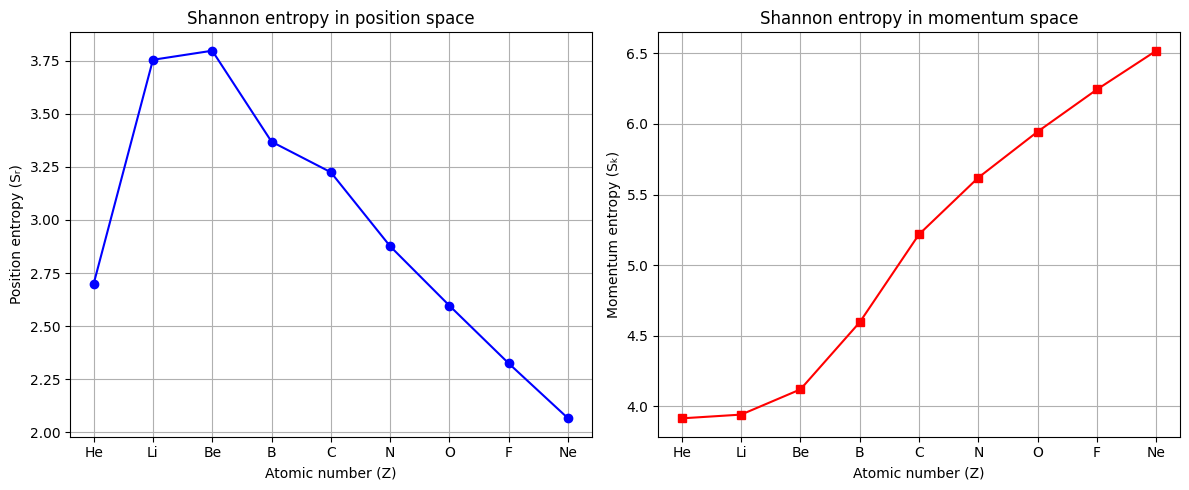


Comparison with reference values:


,Z,Element,S_r,Sr,S_k,Sk
0,2,He,2.698511,2.69851,3.913412,3.91342
1,3,Li,3.755277,3.07144,3.939901,3.99682
2,4,Be,3.798061,3.62386,4.118714,4.19019
3,5,B,3.369074,3.40545,4.594670,4.70590
4,6,C,3.224941,3.10602,5.217907,5.15658
5,7,N,2.875978,2.80169,5.619992,5.54934
6,8,O,2.595823,2.55054,5.945763,5.86737
7,9,F,2.323529,2.29883,6.244809,6.16333
8,10,Ne,2.064755,2.05514,6.519392,6.43707


In [8]:
def calculate_shannon_entropy(element, r_max=100, k_max=100, num_points=10000):
    """Calculates Shannon entropy for a specific element"""
    try:
        # Create grid
        r = np.linspace(1e-10, r_max, num_points)
        k = np.linspace(1e-10, k_max, num_points)
        
        # Probability densities
        rho_r = position_density(r, element)
        rho_k = momentum_density(k, element)
        
        # Entropy integrals (avoid log(0))
        with np.errstate(divide='ignore', invalid='ignore'):
            integrand_r = np.where(rho_r > 1e-12, rho_r * np.log(rho_r) * r**2, 0)
            integrand_k = np.where(rho_k > 1e-12, rho_k * np.log(rho_k) * k**2, 0)
        
        S_r = -4 * np.pi * trapezoid(integrand_r, r)
        S_k = -4 * np.pi * trapezoid(integrand_k, k)
        
        return S_r, S_k
    except Exception as e:
        print(f"Error in entropy calculation for {element}: {str(e)}")
        return np.nan, np.nan

# Create DataFrame for results
entropy_results = pd.DataFrame(columns=['Element', 'S_r', 'S_k'])

# Calculate for all elements
for element in atomic_numbers.keys():
    S_r, S_k = calculate_shannon_entropy(element)
    entropy_results.loc[len(entropy_results)] = [element, S_r, S_k]
    print(f"Completed calculation for {element}: S_r={S_r:.6f}, S_k={S_k:.6f}")

# Add atomic numbers and total entropy
entropy_results['Z'] = entropy_results['Element'].map(atomic_numbers)
entropy_results['S_total'] = entropy_results['S_r'] + entropy_results['S_k']

# Display results
print("\nSummary of Shannon entropy results:")
display(entropy_results[['Z', 'Element', 'S_r', 'S_k', 'S_total']])

# Create figure for entropy plots
plt.figure(figsize=(12, 5))

# Plot for Sr (position space entropy)
plt.subplot(1, 2, 1)
plt.plot(entropy_results['Z'], entropy_results['S_r'], 'o-', color='blue')
plt.xlabel('Atomic number (Z)')
plt.ylabel('Position entropy (Sᵣ)')
plt.title('Shannon entropy in position space')
plt.xticks(entropy_results['Z'], entropy_results['Element'])
plt.grid(True)

# Plot for Sk (momentum space entropy)
plt.subplot(1, 2, 2)
plt.plot(entropy_results['Z'], entropy_results['S_k'], 's-', color='red')
plt.xlabel('Atomic number (Z)')
plt.ylabel('Momentum entropy (Sₖ)')
plt.title('Shannon entropy in momentum space')
plt.xticks(entropy_results['Z'], entropy_results['Element'])
plt.grid(True)

plt.tight_layout()
plt.show()

# Check against expected values (from entropy_data.csv)
if 'entropy_data.csv' in os.listdir(os.path.dirname(file_path)):
    ref_data = pd.read_csv(os.path.join(os.path.dirname(file_path), 'entropy_data.csv'))
    entropy_results = entropy_results.merge(ref_data[['Element', 'Sr', 'Sk']], on='Element', how='left')
    print("\nComparison with reference values:")
    display(entropy_results[['Z', 'Element', 'S_r', 'Sr', 'S_k', 'Sk']])

#### Total information entropy: $S = S_r + S_k$

Total information entropy S = Sᵣ + Sₖ for each element:


,Z,Element,S_r,S_k,S_total
0,2,He,2.698511,3.913412,6.611923
1,3,Li,3.755277,3.939901,7.695178
2,4,Be,3.798061,4.118714,7.916775
3,5,B,3.369074,4.594670,7.963744
4,6,C,3.224941,5.217907,8.442848
5,7,N,2.875978,5.619992,8.495970
6,8,O,2.595823,5.945763,8.541586
7,9,F,2.323529,6.244809,8.568338
8,10,Ne,2.064755,6.519392,8.584147


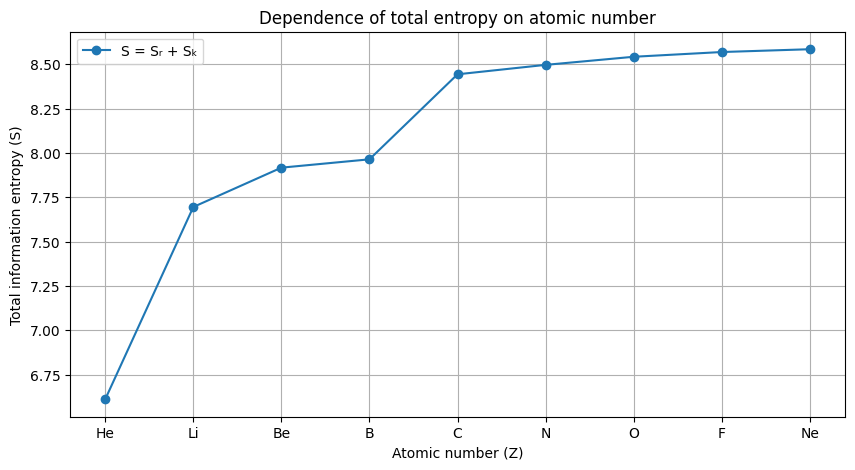

In [9]:
# Calculate total entropy (from previous results)
entropy_results['S_total'] = entropy_results['S_r'] + entropy_results['S_k']

# Display results
print("Total information entropy S = Sᵣ + Sₖ for each element:")
display(entropy_results[['Z', 'Element', 'S_r', 'S_k', 'S_total']])

# Simple plot
plt.figure(figsize=(10, 5))
plt.plot(entropy_results['Z'], entropy_results['S_total'], 'o-', label='S = Sᵣ + Sₖ')
plt.xlabel('Atomic number (Z)')
plt.ylabel('Total information entropy (S)')
plt.title('Dependence of total entropy on atomic number')
plt.xticks(entropy_results['Z'], entropy_results['Element'])
plt.grid(True)
plt.legend()
plt.show()

#### Max information entropy: $S_{max} = 3(1 + ln(\pi))+\frac{3}{2}ln(\frac{4}{9}r^2k^2)$

Maximum information entropy Sₘₐₓ for each element:


,Z,Element,r2,k2,S_max
0,2,He,1.184822,2.861685,7.049299
1,3,Li,6.243020,4.868491,10.339166
2,4,Be,4.411772,6.971574,10.356970
3,5,B,3.090858,9.261974,10.249343
4,6,C,2.337450,11.932177,10.210243
5,7,N,1.750080,14.739568,10.093090
6,8,O,1.412211,17.717029,10.047319
7,9,F,1.148461,20.925253,9.986864
8,10,Ne,0.945446,24.365268,9.923385


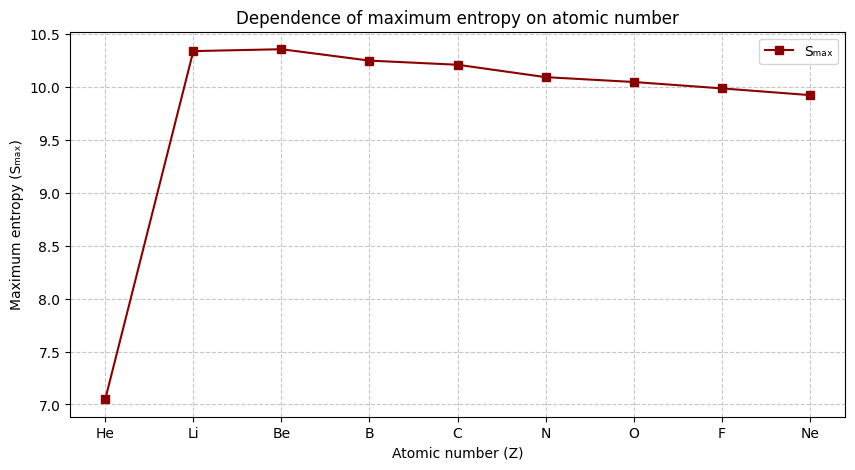

In [10]:
# Calculate <r²> and <k²> for each element
def calculate_r2_k2(element):
    """Calculates mean squared distance and momentum"""
    integrand_r2 = lambda r: position_density(r, element) * r**2 * 4 * np.pi * r**2
    integrand_k2 = lambda k: momentum_density(k, element) * k**2 * 4 * np.pi * k**2
    
    r2 = quad(integrand_r2, 0, np.inf, limit=1000)[0]
    k2 = quad(integrand_k2, 0, np.inf, limit=1000)[0]
    
    return r2, k2

# Calculate Sₘₐₓ for all elements
entropy_results['r2'], entropy_results['k2'] = zip(*entropy_results['Element'].apply(lambda x: calculate_r2_k2(x)))
entropy_results['S_max'] = 3*(1 + np.log(np.pi)) + (3/2)*np.log((4/9)*entropy_results['r2']*entropy_results['k2'])

# Display results
print("Maximum information entropy Sₘₐₓ for each element:")
display(entropy_results[['Z', 'Element', 'r2', 'k2', 'S_max']])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(entropy_results['Z'], entropy_results['S_max'], 's-', color='darkred', label='Sₘₐₓ')
plt.xlabel('Atomic number (Z)')
plt.ylabel('Maximum entropy (Sₘₐₓ)')
plt.title('Dependence of maximum entropy on atomic number')
plt.xticks(entropy_results['Z'], entropy_results['Element'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

#### Order parameter: $\Omega = 1 - S/S_{max}$ 

Order parameter Ω = 1 - S/Sₘₐₓ for each element:


,Z,Element,S_total,S_max,Omega
0,2,He,6.611923,7.049299,0.062045
1,3,Li,7.695178,10.339166,0.255725
2,4,Be,7.916775,10.356970,0.235609
3,5,B,7.963744,10.249343,0.223000
4,6,C,8.442848,10.210243,0.173100
5,7,N,8.495970,10.093090,0.158239
6,8,O,8.541586,10.047319,0.149864
7,9,F,8.568338,9.986864,0.142039
8,10,Ne,8.584147,9.923385,0.134958


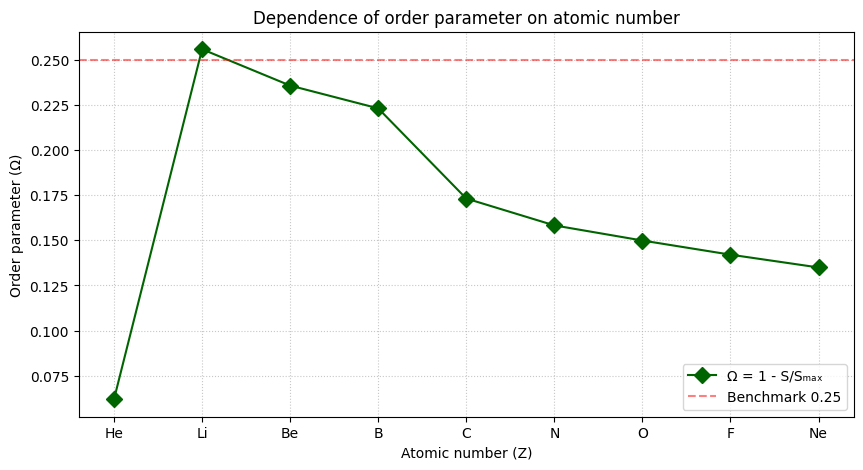

In [11]:
# Calculate Ω
entropy_results['Omega'] = 1 - entropy_results['S_total']/entropy_results['S_max']

# Display results
print("Order parameter Ω = 1 - S/Sₘₐₓ for each element:")
display(entropy_results[['Z', 'Element', 'S_total', 'S_max', 'Omega']].round(6))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(entropy_results['Z'], entropy_results['Omega'], 'D-', color='darkgreen', 
         markersize=8, label='Ω = 1 - S/Sₘₐₓ')
plt.xlabel('Atomic number (Z)')
plt.ylabel('Order parameter (Ω)')
plt.title('Dependence of order parameter on atomic number')
plt.xticks(entropy_results['Z'], entropy_results['Element'])
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()

# Add horizontal benchmark at 0.25
plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.5, label='Benchmark 0.25')
plt.legend()

plt.show()

#### Onisescu complexity: $O = 1/(E_r E_k)$

Onicescu complexity O = 1/(EᵣEₖ) for each element:


,Z,Element,E_r,E_k,Onicescu
0,2,He,0.190605,0.052276,100.361326
1,3,Li,0.342048,0.335778,8.706830
2,4,Be,0.499928,0.259169,7.718076
3,5,B,0.668006,0.091661,16.331828
4,6,C,0.858145,0.053395,21.824122
5,7,N,1.039452,0.029591,32.510923
6,8,O,1.229732,0.018895,43.036507
7,9,F,1.429448,0.012670,55.212844
8,10,Ne,1.641059,0.008851,68.847951


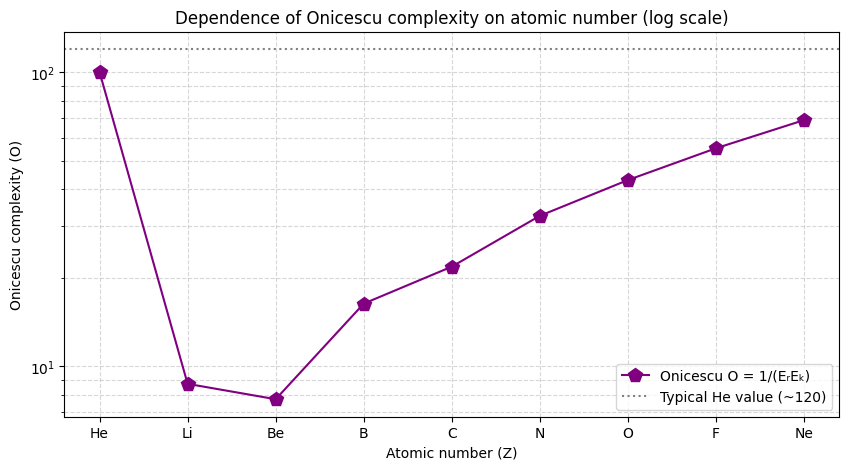

In [12]:
def calculate_er_ek(element):
    """Calculates Eᵣ and Eₖ for an element"""
    # Eᵣ = ∫ ρ²(r) 4πr² dr
    er = quad(lambda r: position_density(r, element)**2 * 4 * np.pi * r**2, 
              0, np.inf, limit=1000)[0]
    
    # Eₖ = ∫ η²(k) 4πk² dk
    ek = quad(lambda k: momentum_density(k, element)**2 * 4 * np.pi * k**2, 
              0, np.inf, limit=1000)[0]
    
    return er, ek

# Calculate for all elements
entropy_results['E_r'], entropy_results['E_k'] = zip(*entropy_results['Element'].apply(calculate_er_ek))
entropy_results['Onicescu'] = 1/(entropy_results['E_r'] * entropy_results['E_k'])

# Display results
print("Onicescu complexity O = 1/(EᵣEₖ) for each element:")
display(entropy_results[['Z', 'Element', 'E_r', 'E_k', 'Onicescu']].round(6))

# Plot
plt.figure(figsize=(10, 5))
plt.semilogy(entropy_results['Z'], entropy_results['Onicescu'], 'p-', 
            color='purple', markersize=10, label='Onicescu O = 1/(EᵣEₖ)')
plt.xlabel('Atomic number (Z)')
plt.ylabel('Onicescu complexity (O)')
plt.title('Dependence of Onicescu complexity on atomic number (log scale)')
plt.xticks(entropy_results['Z'], entropy_results['Element'])
plt.grid(True, which="both", ls="--", alpha=0.5)

# Add reference for He (typical value ~120)
plt.axhline(y=120, color='gray', linestyle=':', label='Typical He value (~120)')
plt.legend()
plt.show()

### Generating dictionary for all elements

In [13]:
# Select and rename columns to match the requested format
output_data = entropy_results[['Z', 'Element', 'S_r', 'S_k', 'S_total', 'S_max', 'Omega', 'Onicescu']]
output_data.columns = ['Z', 'Element', 'Sr', 'Sk', 'S', 'Smax', 'Omega', 'O']

# Round all numerical values to 5 decimal places
output_data = output_data.round(5)

# Save to CSV
output_path = os.path.join(os.path.dirname(file_path), "generated_entropy_data.csv")
output_data.to_csv(output_path, index=False, float_format='%.5f')

print(f"Data successfully saved to {output_path}")
print("\nFinal data:")
display(output_data)

Data successfully saved to /home/konsster/Desktop/AUThPhysDepart/Computational_Quantum_Physics_and_Applications/Project_1/data/generated_entropy_data.csv

Final data:


,Z,Element,Sr,Sk,S,Smax,Omega,O
0,2,He,2.69851,3.91341,6.61192,7.04930,0.06205,100.36133
1,3,Li,3.75528,3.93990,7.69518,10.33917,0.25573,8.70683
2,4,Be,3.79806,4.11871,7.91677,10.35697,0.23561,7.71808
3,5,B,3.36907,4.59467,7.96374,10.24934,0.22300,16.33183
4,6,C,3.22494,5.21791,8.44285,10.21024,0.17310,21.82412
5,7,N,2.87598,5.61999,8.49597,10.09309,0.15824,32.51092
6,8,O,2.59582,5.94576,8.54159,10.04732,0.14986,43.03651
7,9,F,2.32353,6.24481,8.56834,9.98686,0.14204,55.21284
8,10,Ne,2.06476,6.51939,8.58415,9.92338,0.13496,68.84795
